In [ ]:
## 深度学习，使用Pytorch实现基于RNN、LSTM、BiLSTM和GRU的文本分类

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
#torch.set_printoptions(sci_mode=True)

In [ ]:
path = '/content/drive/My Drive/data_sampled.csv'

In [ ]:
def label_to_category(label):
  if label == '词':
    return 0
  elif label == '诗':
    return 1
  elif label == '文言文':
    return 2
  elif label == '新闻':
    return 3
  elif label == '期刊':
    return 4
  else:
    print("标签格式存在异常")

In [ ]:
def get_data(file_path):#获取数据集的文本和标签信息
    data = pd.read_csv(file_path)
    # 取出文本部分
    ci = data[data.类别=='词'].sample(n=1000,random_state=10, axis=0)
    poem = data[data.类别=='诗'].sample(n=1000,random_state=12, axis=0)
    wyw = data[data.类别=='文言文'].sample(n=1000,random_state=15, axis=0)
    news = data[data.类别=='新闻'].sample(n=1000,random_state=16, axis=0)
    journal = data[data.类别=='期刊'].sample(n=1000,random_state=18, axis=0)
    print(len(ci),len(poem),len(wyw),len(news),len(journal))
    # 取出标签部分
    temp = pd.concat([ci,poem,wyw,news,journal])
    temp = temp[['文本','类别']]
    temp.to_csv('/content/drive/My Drive/data_sampled_1000.csv')
    content= data['文本']
    labels = np.asarray([label_to_category(label) for label in data['类别']])
    return content, labels
 
content,labels=get_data(path)

1000 1000 1000 1000 1000


In [ ]:
content

0                                       气 和 玉 烛 ， 睿 化 著 鸿 明
1                                                 缇 管 一 阳 生
2                                 郊 禋 盛 礼 燔 柴 毕 ， 旋 轸 凤 凰 城
3                                             森 罗 仪 卫 振 华 缨
4                                                 载 路 溢 欢 声
                                ...                        
749420    此 外 ，  农 村 地 区 的 交 通 和 信 息 等 基 础 设 施 相 对 薄 弱 ，...
749421    而 堪 萨 斯 太 平 洋 铁 路 和 联 合 太 平 洋 铁 路 的 相 互 融 通 ， ...
749422    在 外 组 建 的 家 庭 自 然 缺 少 象 征 的 意 味 ， 那 只 是 一 个 临 ...
749423          一 些 商 法 学 者 认 为 ， 民 商 合 一 既 无 必 要 也 无 可 能 ，
749424    因 为 近 度 对 于 顾 客 下 次 购 买 影 响 甚 微 ，  而 各 消 费 者 的...
Name: 文本, Length: 749425, dtype: object

In [ ]:
labels

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
word_index = np.load('/content/drive/My Drive/word_index.npy',allow_pickle=True).item()
embeddings_matrix=np.load('/content/drive/My Drive/embedding_matrix.npy')


In [ ]:
word_index

{'，': 0,
 '的': 1,
 '。': 2,
 '、': 3,
 '：': 4,
 '--------------------------------------------------------------------------------': 5,
 '一个': 6,
 '（': 7,
 '年': 8,
 '在': 9,
 '中国': 10,
 '“': 11,
 '了': 12,
 '一': 13,
 '和': 14,
 '”': 15,
 '2017': 16,
 '）': 17,
 ',': 18,
 '为': 19,
 '公司': 20,
 '我': 21,
 '是': 22,
 '有': 23,
 '与': 24,
 '\ue40c': 25,
 '我们': 26,
 '》': 27,
 '也': 28,
 '可以': 29,
 '人': 30,
 '《': 31,
 '月': 32,
 '没有': 33,
 '自己': 34,
 '发展': 35,
 '中': 36,
 '中华人民共和国': 37,
 '市场': 38,
 '等': 39,
 '进行': 40,
 '股份有限公司': 41,
 '对': 42,
 '企业': 43,
 '个': 44,
 '；': 45,
 '工作': 46,
 '上': 47,
 '不': 48,
 '就': 49,
 '他': 50,
 '日': 51,
 '%': 52,
 '被': 53,
 '有限公司': 54,
 '将': 55,
 '他们': 56,
 ')': 57,
 '(': 58,
 '后': 59,
 '都': 60,
 '第一': 61,
 '亿元': 62,
 '这个': 63,
 '10': 64,
 '而': 65,
 '以': 66,
 '问题': 67,
 '就是': 68,
 '2016': 69,
 ':': 70,
 '发行': 71,
 '这': 72,
 '记者': 73,
 '已经': 74,
 '及': 75,
 '到': 76,
 '美国': 77,
 '通过': 78,
 '时间': 79,
 '开始': 80,
 '成为': 81,
 '国家': 82,
 '主要': 83,
 '以及': 84,
 '-': 85,
 '多': 86,
 '于': 

In [ ]:
embeddings_matrix.shape

(1292550, 300)

In [ ]:
#用向量模型处理文本数据
# 序号化 文本，tokenizer句子，并返回每个句子所对应的词语索引
# 由于将词语转化为索引的word_index需要与词向量模型对齐，故在导入词向量模型后再将X进行处理
from keras.preprocessing import sequence
MAX_SEQUENCE_LENGTH=100
def tokenizer(texts, word_index):
    data = []
    for sentence in texts:
        new_sentence = []
        for word in sentence:
            if word!=' ':
                try:
                    new_sentence.append(word_index[word])  # 把文本中的 词语转化为index
                except:
                    new_sentence.append(0)


        data.append(new_sentence)
    # 使用keras的内置函数padding对齐句子,好处是输出numpy数组，不用自己转化了
    data = sequence.pad_sequences(data, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    return data

In [ ]:
X_padded = tokenizer(content, word_index)
del content

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, labels, test_size=0.01, random_state=21) #98:1:1
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=21)

In [ ]:
print(len(X_train),len(X_val),len(X_test))

741930 3747 3748


In [ ]:
#from keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=5)
#y_test = to_categorical(y_test, num_classes=5)
#del X_padded

In [ ]:
X_train

array([[ 5516, 11164,  7230, ...,     0,     0,     0],
       [  354,  5051,  5921, ...,     0,     0,     0],
       [  100, 11510,  4441, ...,     0,     0,     0],
       ...,
       [   48,   427,  9304, ...,     0,     0,     0],
       [ 5312,  9779,    47, ...,     0,     0,     0],
       [ 4558,  1176, 14681, ...,     0,     0,     0]], dtype=int32)

In [ ]:
y_train

array([1, 1, 0, ..., 4, 1, 4])

In [ ]:
#print(X_train.shape, y_train.shape, X_test.shape,y_test.shape)

In [ ]:
import torch.utils.data as Data

x_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
x_val_tensor = torch.LongTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
x_test_tensor = torch.LongTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)
train_data = Data.TensorDataset(x_train_tensor, y_train_tensor) # 将数据放入 torch_dataset
val_data = Data.TensorDataset(x_val_tensor, y_val_tensor)
test_data = Data.TensorDataset(x_test_tensor, y_test_tensor)
BATCH_SIZE = 128
train_loader=Data.DataLoader(
        dataset=train_data,           # 将数据放入loader
        batch_size=BATCH_SIZE,           # 每个数据段大小为  BATCH_SIZE=5
        shuffle=True ,                   # 是否打乱数据的排布
        )
val_loader=Data.DataLoader(
        dataset=val_data,           # 将数据放入loader
        batch_size=BATCH_SIZE,           # 每个数据段大小为  BATCH_SIZE=5
        shuffle=True ,                   # 是否打乱数据的排布
        )
test_loader=Data.DataLoader(
        dataset=test_data,           # 将数据放入loader
        batch_size=BATCH_SIZE,           # 每个数据段大小为  BATCH_SIZE=5
        shuffle=True ,                   # 是否打乱数据的排布
        )
def go(loader):
  for step, (x,y) in enumerate(loader):
    print(x)
    print(y)
    break
go(train_loader)
go(val_loader)
go(test_loader)

tensor([[   19,  5174,   100,  ...,     0,     0,     0],
        [   21,   785,     9,  ...,     0,     0,     0],
        [  834,    19, 18684,  ...,     0,     0,     0],
        ...,
        [11683,   423,  9213,  ...,     0,     0,     0],
        [11300,  6804, 20716,  ...,     0,     0,     0],
        [ 2754,   195,  9415,  ...,     0,     0,     0]])
tensor([0, 4, 4, 1, 1, 1, 4, 2, 4, 0, 3, 4, 3, 4, 0, 2, 1, 4, 3, 0, 3, 1, 0, 0,
        3, 3, 3, 3, 3, 4, 2, 3, 3, 2, 2, 0, 2, 0, 3, 3, 2, 0, 1, 0, 0, 0, 4, 3,
        2, 3, 3, 2, 2, 3, 0, 2, 1, 0, 3, 3, 0, 1, 2, 4, 2, 0, 3, 4, 2, 1, 2, 1,
        3, 2, 3, 2, 3, 3, 2, 3, 2, 4, 4, 2, 2, 1, 1, 2, 3, 0, 1, 1, 3, 0, 3, 4,
        3, 1, 2, 3, 4, 4, 1, 2, 4, 2, 4, 3, 0, 3, 2, 3, 2, 3, 3, 2, 4, 4, 4, 4,
        0, 1, 0, 1, 2, 2, 4, 0])
tensor([[12988,   111,  7646,  ...,     0,     0,     0],
        [ 1084,  4470,   106,  ...,     0,     0,     0],
        [   19,    12,  9351,  ...,     0,     0,     0],
        ...,
        [ 1502,   

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding.from_pretrained(weights_matrix)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class RNN_MODEL(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super(RNN_MODEL,self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        #self.drop = nn.Dropout(p=0.25)
        self.fc = nn.Linear(hidden_size, 5)

    def forward(self, x):        
        out = self.embedding(x)  # [batch_size, seq_len, embeding]=[128, 32, 300]
        #print(out.shape)
        out, _ = self.rnn(out)
        #print(out.shape)
        out = self.fc(out[:, -1, :])  # 句子最后时刻的 hidden state
        #print(out.shape)
        out = F.softmax(out, dim=1)
        return out
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [ ]:
#这个是词向量矩阵的名字
weights_matrix = torch.Tensor(embeddings_matrix)
#print(weights_matrix)


hidden_size = 120 # 隐藏神经元数量
num_layers = 1 # 搭1层
num_epochs = 20 #训练20次
learning_rate = 1e-3 

#初始化模型
rnn_model = RNN_MODEL(weights_matrix,hidden_size, num_layers)
rnn_model.train()

# Training Function

def train(model,optimizer,criterion = nn.CrossEntropyLoss(), train_loader = train_loader, valid_loader = val_loader,
                                             num_epochs = 10,
                                             eval_every = len(train_loader) // 2,
                                             best_valid_loss = float("Inf")
                                             ):
      
    # initialize running values
    running_loss = 0.0
    running_acc = 0.0
    valid_running_loss = 0.0
    valid_running_acc = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for i, (trains, labels) in enumerate(train_loader):   
            labels = labels.to(device)
            trains = trains.to(device)
            output = model(trains)

            loss = criterion(output, labels)
            pred_y = torch.max(output, dim=1)[1].data.cpu().numpy()
            accuracy = ((pred_y == labels.data.cpu().numpy()).astype(int).sum()) / float(labels.size(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            running_acc += accuracy
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for i, (vals, labels) in enumerate(valid_loader):
                      labels = labels.to(device)
                      vals = vals.to(device)
                      output = model(vals)
                      pred_y = torch.max(output, dim=1)[1].data.cpu().numpy()
                      accuracy = ((pred_y == labels.data.cpu().numpy()).astype(int).sum()) / float(labels.size(0))
                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()
                      valid_running_acc += accuracy

                # evaluation
                average_train_loss = running_loss / eval_every
                average_train_acc = running_acc / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                average_valid_acc = valid_running_acc / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0     
                running_acc = 0.0           
                valid_running_loss = 0.0
                valid_running_acc = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_train_acc, average_valid_loss,average_valid_acc))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    #save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    #save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    #save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
rnn_model = rnn_model.to(device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
train(model=rnn_model, optimizer=optimizer, num_epochs=20)

Epoch [1/20], Step [2898/115940], Train Loss: 1.6038, Train Acc: 0.2159, Valid Loss: 1.6035, Valid Acc: 0.2144
Epoch [1/20], Step [5796/115940], Train Loss: 1.6019, Train Acc: 0.2170, Valid Loss: 1.6028, Valid Acc: 0.2186
Epoch [2/20], Step [8694/115940], Train Loss: 1.6014, Train Acc: 0.2168, Valid Loss: 1.6036, Valid Acc: 0.2153
Epoch [2/20], Step [11592/115940], Train Loss: 1.6007, Train Acc: 0.2156, Valid Loss: 1.6022, Valid Acc: 0.2159
Epoch [3/20], Step [14490/115940], Train Loss: 1.6019, Train Acc: 0.2181, Valid Loss: 1.6021, Valid Acc: 0.2184
Epoch [3/20], Step [17388/115940], Train Loss: 1.6011, Train Acc: 0.2167, Valid Loss: 1.6023, Valid Acc: 0.2177
Epoch [4/20], Step [20286/115940], Train Loss: 1.6010, Train Acc: 0.2174, Valid Loss: 1.6048, Valid Acc: 0.2182
Epoch [4/20], Step [23184/115940], Train Loss: 1.6018, Train Acc: 0.2165, Valid Loss: 1.6021, Valid Acc: 0.2188
Epoch [5/20], Step [26082/115940], Train Loss: 1.6013, Train Acc: 0.2165, Valid Loss: 1.6018, Valid Acc: 0.

In [ ]:
class LSTM_MODEL(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super(LSTM_MODEL,self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.drop = nn.Dropout(p=0.25)
        #self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 5)

    def forward(self, x):        
        out = self.embedding(x)  # [batch_size, seq_len, embeding]=[128, 32, 300]
        #print(out.shape)
        out, _ = self.lstm(out)
        #print(out.shape)
        out = self.fc(out[:, -1, :])  # 句子最后时刻的 hidden state
        #print(out.shape)
        out = F.softmax(out, dim=1)
        return out
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        

In [ ]:
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
#这个是词向量矩阵的名字
weights_matrix = torch.Tensor(embeddings_matrix)
#print(weights_matrix)


hidden_size = 128 # 隐藏神经元数量
num_layers = 1 # 搭1层
num_epochs = 20 #训练20次
learning_rate = 1e-3 

#初始化模型
lstm_model = LSTM_MODEL(weights_matrix,hidden_size, num_layers)
lstm_model.train()

# Training Function

def train(model,optimizer,criterion = nn.CrossEntropyLoss(), train_loader = train_loader, valid_loader = val_loader,
                                             num_epochs = 10,
                                             eval_every = len(train_loader) // 2,
                                             best_valid_loss = float("Inf")
                                             ):
      
    # initialize running values
    running_loss = 0.0
    running_acc = 0.0
    valid_running_loss = 0.0
    valid_running_acc = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for i, (trains, labels) in enumerate(train_loader):   
            labels = labels.to(device)
            trains = trains.to(device)
            output = model(trains)

            loss = criterion(output, labels)
            pred_y = torch.max(output, dim=1)[1].data.cpu().numpy()
            accuracy = ((pred_y == labels.data.cpu().numpy()).astype(int).sum()) / float(labels.size(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            running_acc += accuracy
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for i, (vals, labels) in enumerate(valid_loader):
                      labels = labels.to(device)
                      vals = vals.to(device)
                      output = model(vals)
                      pred_y = torch.max(output, dim=1)[1].data.cpu().numpy()
                      accuracy = ((pred_y == labels.data.cpu().numpy()).astype(int).sum()) / float(labels.size(0))
                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()
                      valid_running_acc += accuracy

                # evaluation
                average_train_loss = running_loss / eval_every
                average_train_acc = running_acc / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                average_valid_acc = valid_running_acc / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0     
                running_acc = 0.0           
                valid_running_loss = 0.0
                valid_running_acc = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_train_acc, average_valid_loss,average_valid_acc))
    
    save_metrics('/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
lstm_model = lstm_model.to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
train(model=lstm_model, optimizer=optimizer, num_epochs=20)

Epoch [1/20], Step [5796/115940], Train Loss: 1.0765, Train Acc: 0.8272, Valid Loss: 1.0520, Valid Acc: 0.8515
Epoch [2/20], Step [8694/115940], Train Loss: 1.0451, Train Acc: 0.8586, Valid Loss: 1.0374, Valid Acc: 0.8672
Epoch [2/20], Step [11592/115940], Train Loss: 1.0325, Train Acc: 0.8716, Valid Loss: 1.0392, Valid Acc: 0.8649
Epoch [3/20], Step [14490/115940], Train Loss: 1.0283, Train Acc: 0.8755, Valid Loss: 1.0340, Valid Acc: 0.8720
Epoch [3/20], Step [17388/115940], Train Loss: 1.0217, Train Acc: 0.8824, Valid Loss: 1.0268, Valid Acc: 0.8770
Epoch [4/20], Step [20286/115940], Train Loss: 1.0174, Train Acc: 0.8866, Valid Loss: 1.0286, Valid Acc: 0.8750
Epoch [4/20], Step [23184/115940], Train Loss: 1.0169, Train Acc: 0.8871, Valid Loss: 1.0246, Valid Acc: 0.8800
Epoch [5/20], Step [26082/115940], Train Loss: 1.0120, Train Acc: 0.8922, Valid Loss: 1.0207, Valid Acc: 0.8829
Epoch [5/20], Step [28980/115940], Train Loss: 1.0110, Train Acc: 0.8931, Valid Loss: 1.0222, Valid Acc: 0

Model loaded from <== /metrics.pt


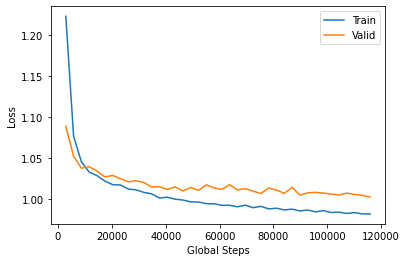

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

train_loss_list, valid_loss_list, global_steps_list = load_metrics('/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
def evaluate(model, test_loader, version='title', threshold=0.5):


    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for i, (trains, labels) in enumerate(test_loader):          
            #labels = labels.to(device)
            labels=np.asarray(labels.cpu())
            #print(labels)
            trains = trains.to(device)
            output = model(trains)
            #output = (output > threshold).int()
            output=np.asarray(output.cpu())
            output=np.argmax(output,1)
            #print(output)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=['词','诗','文言文','新闻','期刊'], digits=4))
    %matplotlib inline
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['ci','poem','wyw','news','journal'])
    ax.yaxis.set_ticklabels(['ci','poem','wyw','news','journal'])
    

Classification Report:
              precision    recall  f1-score   support

           词     0.8849    0.8753    0.8801       738
           诗     0.8721    0.9602    0.9140       753
         文言文     0.8968    0.8391    0.8670       746
          新闻     0.9280    0.9030    0.9153       742
          期刊     0.9272    0.9272    0.9272       769

    accuracy                         0.9013      3748
   macro avg     0.9018    0.9010    0.9007      3748
weighted avg     0.9019    0.9013    0.9009      3748



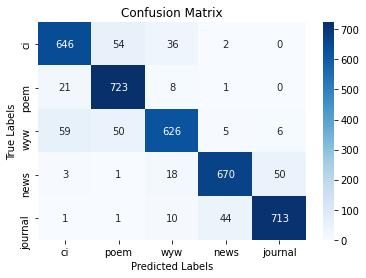

In [ ]:
evaluate(lstm_model, test_loader)

In [ ]:
class BLSTM_MODEL(nn.Module):      #双向LSTM
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super(BLSTM_MODEL,self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True) #启用bidirectional参数
        self.drop = nn.Dropout(p=0.25)
        self.fc = nn.Linear(2*hidden_size, 5) #双向LSTM的输出是隐藏神经元数量乘以2

    def forward(self, x):        
        out = self.embedding(x)  # [batch_size, seq_len, embeding]=[128, 100, 300]
        #print(out.shape)
        out, _ = self.lstm(out)
        #print(out.shape)
        out = self.fc(out[:, -1, :])  # 句子最后时刻的 hidden state
        #print(out.shape)
        out = F.softmax(out, dim=1)
        return out
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
        

In [ ]:
#这个是词向量矩阵的名字
weights_matrix = torch.Tensor(embeddings_matrix)
#print(weights_matrix)


hidden_size = 128 # 隐藏神经元数量
num_layers = 1 # 搭1层
num_epochs = 20 #训练20次
learning_rate = 1e-3 

#初始化双向LSTM模型
lstm_model = BLSTM_MODEL(weights_matrix,hidden_size, num_layers)
lstm_model.train()

# Training Function

def train(model,optimizer,criterion = nn.CrossEntropyLoss(), train_loader = train_loader, valid_loader = val_loader,
                                             num_epochs = 10,
                                             eval_every = len(train_loader) // 2,
                                             best_valid_loss = float("Inf")
                                             ):
      
    # initialize running values
    running_loss = 0.0
    running_acc = 0.0
    valid_running_loss = 0.0
    valid_running_acc = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for i, (trains, labels) in enumerate(train_loader):   
            labels = labels.to(device)
            trains = trains.to(device)
            output = model(trains)

            loss = criterion(output, labels)
            pred_y = torch.max(output, dim=1)[1].data.cpu().numpy()
            accuracy = ((pred_y == labels.data.cpu().numpy()).astype(int).sum()) / float(labels.size(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            running_acc += accuracy
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for i, (vals, labels) in enumerate(valid_loader):
                      labels = labels.to(device)
                      vals = vals.to(device)
                      output = model(vals)
                      pred_y = torch.max(output, dim=1)[1].data.cpu().numpy()
                      accuracy = ((pred_y == labels.data.cpu().numpy()).astype(int).sum()) / float(labels.size(0))
                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()
                      valid_running_acc += accuracy

                # evaluation
                average_train_loss = running_loss / eval_every
                average_train_acc = running_acc / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                average_valid_acc = valid_running_acc / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0     
                running_acc = 0.0           
                valid_running_loss = 0.0
                valid_running_acc = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_train_acc, average_valid_loss,average_valid_acc))
    
    #save_metrics('/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
blstm_model = lstm_model.to(device)
optimizer = torch.optim.Adam(blstm_model.parameters(), lr=0.001)
train(model=blstm_model, optimizer=optimizer, num_epochs=20)

Epoch [1/20], Step [2898/115940], Train Loss: 1.2330, Train Acc: 0.6647, Valid Loss: 1.0990, Valid Acc: 0.8064
Epoch [1/20], Step [5796/115940], Train Loss: 1.0776, Train Acc: 0.8261, Valid Loss: 1.0655, Valid Acc: 0.8388
Epoch [2/20], Step [8694/115940], Train Loss: 1.0509, Train Acc: 0.8528, Valid Loss: 1.0447, Valid Acc: 0.8597
Epoch [2/20], Step [11592/115940], Train Loss: 1.0343, Train Acc: 0.8695, Valid Loss: 1.0456, Valid Acc: 0.8583
Epoch [3/20], Step [14490/115940], Train Loss: 1.0311, Train Acc: 0.8729, Valid Loss: 1.0331, Valid Acc: 0.8715
Epoch [3/20], Step [17388/115940], Train Loss: 1.0233, Train Acc: 0.8807, Valid Loss: 1.0301, Valid Acc: 0.8734
Epoch [4/20], Step [20286/115940], Train Loss: 1.0211, Train Acc: 0.8829, Valid Loss: 1.0252, Valid Acc: 0.8788
Epoch [4/20], Step [23184/115940], Train Loss: 1.0172, Train Acc: 0.8868, Valid Loss: 1.0337, Valid Acc: 0.8702
Epoch [5/20], Step [26082/115940], Train Loss: 1.0149, Train Acc: 0.8892, Valid Loss: 1.0287, Valid Acc: 0.

In [ ]:
del X_train, X_test, y_train, y_test, X_val, y_val

Classification Report:
              precision    recall  f1-score   support

           词     0.8717    0.8930    0.8822       738
           诗     0.8841    0.9216    0.9025       753
         文言文     0.8999    0.8552    0.8770       746
          新闻     0.9367    0.8976    0.9167       742
          期刊     0.9149    0.9363    0.9254       769

    accuracy                         0.9010      3748
   macro avg     0.9014    0.9007    0.9008      3748
weighted avg     0.9015    0.9010    0.9009      3748



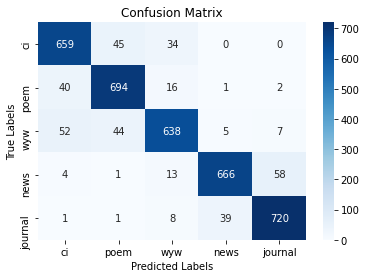

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
evaluate(blstm_model, test_loader)

In [ ]:
class GRU_MODEL(nn.Module): #GRU
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super(GRU_MODEL,self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.drop = nn.Dropout(p=0.25)
        self.fc = nn.Linear(hidden_size, 5)

    def forward(self, x):        
        out = self.embedding(x)  # [batch_size, seq_len, embeding]=[128, 32, 300]
        #print(out.shape)
        out, _ = self.gru(out)  
        #print(out.shape)
        out = self.fc(out[:, -1, :])  # 句子最后时刻的 hidden state
        #print(out.shape)
        out = F.softmax(out, dim=1)
        return out
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [ ]:
#这个是词向量矩阵的名字
weights_matrix = torch.Tensor(embeddings_matrix)
#print(weights_matrix)


hidden_size = 128 # 隐藏神经元数量
num_layers = 1 # 搭1层
num_epochs = 20 #训练20次
learning_rate = 1e-3 

#初始化GRU模型
gru_model = GRU_MODEL(weights_matrix,hidden_size, num_layers)
gru_model.train()


def train(model,optimizer,criterion = nn.CrossEntropyLoss(), train_loader = train_loader, valid_loader = val_loader,
                                             num_epochs = 10,
                                             eval_every = len(train_loader) // 2,
                                             best_valid_loss = float("Inf")
                                             ):
      
    # initialize running values
    running_loss = 0.0
    running_acc = 0.0
    valid_running_loss = 0.0
    valid_running_acc = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for i, (trains, labels) in enumerate(train_loader):   
            labels = labels.to(device)
            trains = trains.to(device)
            output = model(trains)

            loss = criterion(output, labels)
            pred_y = torch.max(output, dim=1)[1].data.cpu().numpy()
            accuracy = ((pred_y == labels.data.cpu().numpy()).astype(int).sum()) / float(labels.size(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            running_acc += accuracy
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for i, (vals, labels) in enumerate(valid_loader):
                      labels = labels.to(device)
                      vals = vals.to(device)
                      output = model(vals)
                      pred_y = torch.max(output, dim=1)[1].data.cpu().numpy()
                      accuracy = ((pred_y == labels.data.cpu().numpy()).astype(int).sum()) / float(labels.size(0))
                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()
                      valid_running_acc += accuracy

                # evaluation
                average_train_loss = running_loss / eval_every
                average_train_acc = running_acc / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                average_valid_acc = valid_running_acc / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0     
                running_acc = 0.0           
                valid_running_loss = 0.0
                valid_running_acc = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_train_acc, average_valid_loss,average_valid_acc))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    #save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    #save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    #save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
gru_model = gru_model.to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
train(model=gru_model, optimizer=optimizer, num_epochs=20)

Epoch [1/20], Step [2898/115940], Train Loss: 1.1392, Train Acc: 0.7616, Valid Loss: 1.0658, Valid Acc: 0.8377
Epoch [1/20], Step [5796/115940], Train Loss: 1.0552, Train Acc: 0.8483, Valid Loss: 1.0458, Valid Acc: 0.8575
Epoch [2/20], Step [8694/115940], Train Loss: 1.0334, Train Acc: 0.8703, Valid Loss: 1.0451, Valid Acc: 0.8553
Epoch [2/20], Step [11592/115940], Train Loss: 1.0216, Train Acc: 0.8821, Valid Loss: 1.0556, Valid Acc: 0.8451
Epoch [3/20], Step [14490/115940], Train Loss: 1.0136, Train Acc: 0.8904, Valid Loss: 1.0263, Valid Acc: 0.8781
Epoch [3/20], Step [17388/115940], Train Loss: 1.0099, Train Acc: 0.8939, Valid Loss: 1.0160, Valid Acc: 0.8883
Epoch [4/20], Step [20286/115940], Train Loss: 1.0058, Train Acc: 0.8984, Valid Loss: 1.0219, Valid Acc: 0.8817
Epoch [4/20], Step [23184/115940], Train Loss: 1.0051, Train Acc: 0.8990, Valid Loss: 1.0227, Valid Acc: 0.8817
Epoch [5/20], Step [26082/115940], Train Loss: 1.0008, Train Acc: 0.9034, Valid Loss: 1.0069, Valid Acc: 0.

Classification Report:
              precision    recall  f1-score   support

           词     0.8601    0.9079    0.8833       738
           诗     0.8778    0.9349    0.9055       753
         文言文     0.9209    0.8271    0.8715       746
          新闻     0.9423    0.9016    0.9215       742
          期刊     0.9187    0.9402    0.9293       769

    accuracy                         0.9026      3748
   macro avg     0.9039    0.9023    0.9022      3748
weighted avg     0.9040    0.9026    0.9024      3748



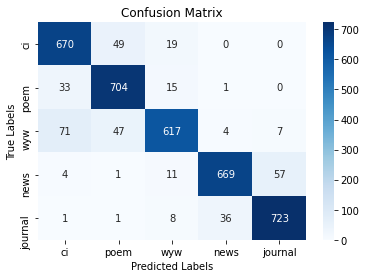

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

evaluate(gru_model, test_loader)